# Song selection algorithm


In [1]:
import polars as pl
import numpy as np
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [5]:
SEED = 88564

spotify = pl.read_csv('spotify-dataset-combined.csv')
all_genres = spotify[:, 'track_genre'].unique()

rng = np.random.default_rng(SEED)
ids = spotify['track_id'].to_numpy()
ids = list(rng.choice(ids, 50, replace=False))

queried_songs = spotify.filter(pl.col('track_id').is_in(ids))
queried_genres = queried_songs[:,'track_genre']

queried_genres = pl.concat((
    queried_genres,
    all_genres.filter(~pl.col('track_genre').is_in(queried_genres['track_genre']))
))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(queried_genres.to_numpy().flatten())

importance = np.zeros((1, tfidf_matrix.shape[0]))
for i in range(0, queried_songs.shape[0]):
	ans = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix)
	importance += ans

best_rec_genres = pl.DataFrame({
    'track_genre': queried_genres['track_genre'],
    'importance': importance.T.flatten()
}).unique()

best_rec_genres = best_rec_genres.sort('importance', descending=True)
best_rec_genres = best_rec_genres.filter(pl.col('importance') >= 0.8)

Above is the first part of the first part of the algorithm, which task was to select relevant genres.  
The algorithm is split in two parts for I wanted to showcase both parts of the engine in distinct workspaces.  
For now though, example listening history is randomly generated for the ease of verifing elbow method.

In [209]:
# only songs from specified genres are relevant
relevant_records = spotify.filter(pl.col('track_genre').is_in(best_rec_genres['track_genre']))

# queried songs excluded from selection, obviously
relevant_records = relevant_records.filter(~pl.col('track_id').is_in(queried_songs['track_id']))
print(relevant_records.shape)
relevant_records.head()

(43581, 20)


track_id,artists,album_name,track_name,popularity,duration_ms,explicitlang,danceability,energy,musickey,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
str,str,str,str,i64,i64,bool,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,i64,str
"""5SuOikwiRyPMVo...","""Gen Hoshino""","""Comedy""","""Comedy""",73,230666,false,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917,4,"""acoustic"""
"""4qPNDBW1i3p13q...","""Ben Woodward""","""Ghost (Acousti...","""Ghost - Acoust...",55,149610,false,0.42,0.166,1,-17.235,1,0.0763,0.924,0.000006,0.101,0.267,77.489,4,"""acoustic"""
"""1iJBSr7s7jYXzM...","""Ingrid Michael...","""To Begin Again...","""To Begin Again...",57,210826,false,0.438,0.359,0,-9.734,1,0.0557,0.21,0.0,0.117,0.12,76.332,4,"""acoustic"""
"""6lfxq3CG4xtTiE...","""Kina Grannis""","""Crazy Rich Asi...","""Can't Help Fal...",71,201933,false,0.266,0.0596,0,-18.515,1,0.0363,0.905,0.0000707,0.132,0.143,181.74,3,"""acoustic"""
"""5vjLSffimiIP26...","""Chord Overstre...","""Hold On""","""Hold On""",82,198853,false,0.618,0.443,2,-9.681,1,0.0526,0.469,0.0,0.0829,0.167,119.949,4,"""acoustic"""


In [1]:
numeric_columns = (
	'popularity', 'danceability', 'energy', 'musickey',
  'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
	'liveness', 'valence', 'tempo'
	# for now without similarity score
)

In [ ]:
', '.join(numeric_columns)

Most of the features are already normalised to the range of `[0;1]`, so I went with manual normalisation of the rest reather than using some predefined normaliser. This way denormalisation will be slighly easier, and we will need to denormalise clusters' centers later on. Normalisation values based on [Spotify's API documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-analysis).

In [211]:
display(spotify.select(numeric_columns).describe())

relevant_records = relevant_records.with_columns(
	popularity = pl.col('popularity') / 100,
	musickey = pl.col('musickey') / 11,
	loudness = pl.col('loudness') / 60,
	tempo = pl.col('tempo') / 250
)

queried_songs = queried_songs.with_columns(
	popularity = pl.col('popularity') / 100,
	musickey = pl.col('musickey') / 11,
	loudness = pl.col('loudness') / 60,
	tempo = pl.col('tempo') / 250
)

display(queried_songs.select(numeric_columns).describe())

describe,popularity,danceability,energy,musickey,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",92836.0,92836.0,92836.0,92836.0,92836.0,92836.0,92836.0,92836.0,92836.0,92836.0,92836.0,92836.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",32.898218,0.563127,0.633536,5.285363,-8.512263,0.634754,0.088609,0.326707,0.175663,0.216232,0.467586,122.028613
"""std""",20.78204,0.177082,0.255479,3.562454,5.212617,0.481502,0.113809,0.337305,0.32529,0.193712,0.262416,30.110434
"""min""",0.0,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""max""",100.0,0.985,1.0,11.0,4.532,1.0,0.965,0.996,1.0,1.0,0.995,243.372
"""median""",33.0,0.577,0.674,5.0,-7.211,1.0,0.0492,0.186,0.0000656,0.132,0.455,122.006


describe,popularity,danceability,energy,musickey,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.344,0.54772,0.6297,0.525455,-0.142377,0.72,0.079626,0.355275,0.237846,0.193684,0.42111,0.492212
"""std""",0.208522,0.174104,0.301131,0.32921,0.091511,0.453557,0.056592,0.369658,0.38766,0.125882,0.268048,0.114888
"""min""",0.0,0.126,0.0301,0.0,-0.429167,0.0,0.0301,0.000006,0.0,0.0495,0.0377,0.314656
"""max""",0.74,0.828,0.996,1.0,-0.031833,1.0,0.318,0.994,0.968,0.674,0.962,0.768336
"""median""",0.345,0.5575,0.6325,0.590909,-0.107758,1.0,0.058,0.246,0.000012,0.1345,0.388,0.479942


In [212]:
dists = []
max_k = min(queried_songs.shape[0], 50)

for k in range(1, max_k):
	kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
	kmeans.fit(queried_songs.select(numeric_columns).to_numpy())
	dists.append(kmeans.inertia_)

dists

[43.02036998690983,
 32.409205790194406,
 24.383038391013947,
 19.947467333843623,
 16.72222276649464,
 14.068139646687396,
 12.407486940261641,
 11.148093035952199,
 10.91178234546474,
 9.90121577811307,
 8.875258284085831,
 8.079181877863473,
 7.365409818211583,
 6.770774945629911,
 6.310033919689477,
 5.931457757179559,
 5.268319693436472,
 5.009840376013221,
 4.514538668000268,
 4.0559677957017515,
 3.773093177037219,
 3.5337728237361654,
 3.2868979210321694,
 3.0255650355180688,
 2.842712147279607,
 2.599426875882779,
 2.4435567041155006,
 2.2962590427935003,
 2.0893051038615336,
 1.88989160185949,
 1.7672368411497494,
 1.6196823096469428,
 1.4494651071946907,
 1.3195988700111008,
 1.1277792062205008,
 1.0109491990014667,
 0.8570820370962385,
 0.7566740728555107,
 0.6715738662134537,
 0.5905757667332315,
 0.5110119199038456,
 0.43029477485029,
 0.35078843883228994,
 0.27600361354002634,
 0.20550281687645686,
 0.15330250792623462,
 0.10279003707772041,
 0.06080051972251986,
 0.0283

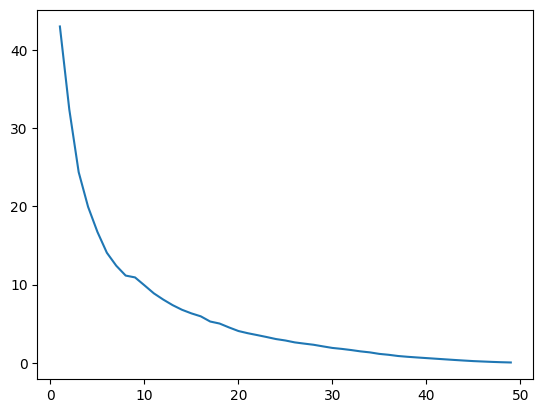

In [213]:
plt.plot(list(range(1, max_k)), dists)

As you can see, elbow method doesn't seem to be an efficient measure of clustering quality, since there is no elbow visible. Trying to automate the process of choosing right number of clusters based on this method with such a smooth divergence can only introduce problems of choosing too big or too small `k`. The former would lead to extended computations and thus waiting times, while the latter might make centroids' characteristics vanish (approach average values) and thus not fully reflect the vibe of queried songs.  
  
Because of those two reasons I'm gonna rely on the KISS rule. Hard-coded number of clusters will lower the complexity and in turn improve the performance as well as ensure the variety and relevance of recommendations.

In [214]:
N = queried_songs.shape[0] * 2 // 5
kmeans = KMeans(n_clusters=N, n_init=10, random_state=0)
kmeans.fit(queried_songs.select(numeric_columns).to_numpy())

songs_centroids = pl.DataFrame(kmeans.cluster_centers_, schema=numeric_columns)

songs_centroids = songs_centroids.with_columns(
	popularity = pl.col('popularity') * 100,
	musickey = pl.col('musickey') * 11,
	loudness = pl.col('loudness') * 60,
	tempo = pl.col('tempo') * 250
)

display(songs_centroids)
songs_centroids.describe()

popularity,danceability,energy,musickey,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
50.0,0.772,0.437,8.0,-10.685,1.0,0.0516,0.45,0.559,0.129,0.191,119.993
46.5,0.554,0.8305,6.0,-4.5745,0.0,0.10665,0.0445,0.00197,0.08025,0.185,139.913
55.0,0.6635,0.686,5.25,-7.29075,1.0,0.102425,0.085597,0.008456,0.133575,0.25925,121.2145
61.0,0.506667,0.426333,0.333333,-9.687,1.0,0.071133,0.781667,0.00123,0.124833,0.304,145.625
32.8,0.3898,0.097,8.6,-20.4194,1.0,0.04206,0.954,0.9108,0.1129,0.10226,100.3152
49.25,0.46675,0.922,9.25,-3.3465,1.0,0.107975,0.025331,0.0011,0.26225,0.482,162.24525
13.0,0.271333,0.968333,7.333333,-5.519,1.0,0.1325,0.009921,0.721333,0.258,0.305,130.219667
21.75,0.57275,0.42875,1.5,-9.023,0.0,0.0518,0.79625,5.2500e-7,0.204,0.45425,129.57075
33.0,0.7475,0.672,4.0,-7.6395,0.0,0.0697,0.4395,0.00076,0.523,0.738,109.9385


describe,popularity,danceability,energy,musickey,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",31.748333,0.560973,0.607879,5.584167,-9.133866,0.65,0.077387,0.320087,0.29022,0.192595,0.409935,122.642868
"""std""",19.805891,0.152785,0.269136,3.710978,5.001203,0.48936,0.032158,0.341116,0.40826,0.112118,0.260585,22.488167
"""min""",0.0,0.271333,0.097,0.0,-20.4194,0.0,0.0355,0.000212,0.0,0.08025,0.0405,91.504667
"""max""",63.0,0.772,0.993,11.0,-3.3465,1.0,0.157633,0.977,0.937,0.523,0.938,175.004
"""median""",30.9,0.588208,0.612167,6.0,-7.465125,1.0,0.070387,0.1221,0.0016,0.142142,0.3045,120.60375


In [228]:
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(relevant_records.select(numeric_columns).to_numpy())

NearestNeighbors(n_neighbors=3)

In [245]:
distances, indices = neigh.kneighbors(queried_songs.select(numeric_columns).to_numpy())

distances = distances.flatten()
indices = indices.flatten()

proposed = pl.DataFrame({
	'distances': distances,
	'indices': indices
})

proposed = proposed.sort('distances', descending=True)

recommendations = relevant_records[proposed['indices'].head(30),:]

In [246]:
display(queried_songs.select(('track_id', 'artists', 'album_name', 'track_name', 'track_genre')))
display(recommendations.select(('track_id', 'artists', 'album_name', 'track_name', 'track_genre')))

track_id,artists,album_name,track_name,track_genre
str,str,str,str,str
"""0KF5nzdiqZlxVK...","""Ben Rector""","""Brand New""","""30,000 Feet""","""acoustic"""
"""0XsYX3MLhyIW2n...","""Mazzy Star""","""sadsadchristma...","""Flowers In Dec...","""alt-rock"""
"""56sk7jBpZV0CD3...","""Three Days Gra...","""One-X""","""Animal I Have ...","""alt-rock"""
"""0nm0bdksXzUJwJ...","""畠中 祐""","""DYING WISH""","""DYING WISH""","""anime"""
"""2ilMGd1JXL1xBX...","""Absu""","""Tara""","""She Cries The ...","""black-metal"""
"""1bMvYcb56PjZmx...","""Deströyer 666""","""Wildfire""","""Wildfire""","""black-metal"""
"""6YhXnVP8iOuM35...","""Rap Box;Fabio ...","""A Divina Coméd...","""A Divina Coméd...","""brazil"""
"""2dz5fCXiNZk4W5...","""Craig Armstron...","""Love Actually ...","""Glasgow Love T...","""british"""
"""28WoBIA4EDVvxi...","""JUNNY;lullaboy...","""nostalgia""","""solo""","""chill"""


track_id,artists,album_name,track_name,track_genre
str,str,str,str,str
"""2lp8pNSPQawnZR...","""SHRK;Shiloh Dy...","""Lost in Love""","""A Love Letter ...","""sad"""
"""3H2QL13RLffEoH...","""Moonkids""","""Somebody""","""Somebody""","""french"""
"""3o7IlOuf5r0zoB...","""Sex Prisoner""","""Sex Prisoner""","""Unconditional ...","""grindcore"""
"""1tfAVU1HIrtlr7...","""Kochetkovv""","""I Love You, Th...","""I Love You, Th...","""chill"""
"""775OxWq9wfVzmV...","""Alexandre Desp...","""Harry Potter a...","""Statues""","""french"""
"""4NkhtB8wNqphhD...","""Igor Talkov""","""Я вернусь""","""Чистые пруды""","""romance"""
"""6Jq8qDJ4qY6m4A...","""Alexandre Desp...","""The Lost King ...","""Digging The R""","""french"""
"""7fKS7D0r163xi3...","""Agoraphobic No...","""Agorapocalypse...","""White On White...","""grindcore"""
"""0vu2Ew3aZ10EB3...","""Stanisław Soyk...","""Action Direct:...","""Tale IV""","""classic polish..."
